# Install, import libraries and Set parameters

In [1]:
# !pip install decord
# !pip install av
!pip install torchsummary

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/tsn-tsm-modules')
from ops import models
from ops.transforms import *

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchsummary import summary

from PIL import Image
import numpy as np
import pandas as pd
import os
import wandb
import random

In [5]:
# parameters
BATCH_SIZE = 12 ## can double batch size with 2 GPUs
NUM_EPOCHS = 100
NUM_CLASSES = 11
CLIP_DURATION = 16
LEARNING_RATE = 0.005
INPUT_SIZE = (3,224,224)
DATA_SAMPLE = 'uniform'

CHECKPOINT_PATH = "/kaggle/working/TSM_ResNet50.pth"
# DATA_DIR = "/kaggle/input/ucf101/UCF101/UCF-101"
# SPLITS_DIR = "/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist"
# CLASS_IND = os.path.join(SPLITS_DIR, "classInd.txt")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [ ]:
output_file = "/kaggle/working/train.txt"
ucf11 = "/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg"
labels = [] # labels[i] = name of class with index i

with open(output_file, "w") as f:
    x = -1
    for action_folder in os.listdir(ucf11):
        action_folder_path = os.path.join(ucf11, action_folder)
        x +=1
        if os.path.isdir(action_folder_path):
            labels.append(action_folder)
            print(action_folder_path)
            for group_folder in os.listdir(action_folder_path):
                group_folder_path = os.path.join(action_folder_path, group_folder)
                if os.path.isdir(group_folder_path):
                    for video_file in os.listdir(group_folder_path):
                        video_file_path = os.path.join(group_folder_path, video_file)
                        if video_file.endswith(".mpg") or video_file.endswith(".avi"):
                            f.write(f"{video_file_path} {x}\n")

print(labels)

/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/biking
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/trampoline_jumping
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/swing
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/walking
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/golf_swing
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/soccer_juggling
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/tennis_swing
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/volleyball_spiking
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/basketball
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/horse_riding
/kaggle/input/realistic-action-recognition-ucf50-dataset/UCF11_updated_mpg/diving
['biking', 'trampoline_jumping', 'swing', 'wa

In [7]:
train_df = pd.read_csv("train.txt",sep = " ",header = None,names = ['path','class'])
train_df['path'] = train_df['path'].str.replace(ucf11, '', regex=False).str.lstrip("\\")
train_df

,path,class
0,/biking/v_biking_05/v_biking_05_05.mpg,0
1,/biking/v_biking_05/v_biking_05_04.mpg,0
2,/biking/v_biking_05/v_biking_05_08.mpg,0
3,/biking/v_biking_05/v_biking_05_01.mpg,0
4,/biking/v_biking_05/v_biking_05_02.mpg,0
...,...,...
1595,/diving/v_diving_21/v_diving_21_02.mpg,10
1596,/diving/v_diving_18/v_diving_18_04.mpg,10
1597,/diving/v_diving_18/v_diving_18_01.mpg,10
1598,/diving/v_diving_18/v_diving_18_03.mpg,10


In [8]:
class_counts = train_df['class'].value_counts()
print(class_counts)

class
9     198
6     167
10    156
5     156
0     145
4     142
8     141
2     137
3     123
1     119
7     116
Name: count, dtype: int64


In [ ]:
def prepare_data(video_path, _resize, num_classes, num_frames):
    content = []
    labels = []
    # crop = transforms.CenterCrop(_resize)
    
    for i in range(num_classes):
        df_temp = train_df[train_df['class'] == i]
        if not df_temp.empty:
            path = df_temp['path'].tolist()
            content.extend(path)
            labels.extend([i] * len(path))
        else:
            print(f"Class {i} không có video nào!")

    if len(content) == 0:
        raise ValueError("Không có video nào trong khoảng class được chọn!")

    content = np.array(content)
    videos = []
    y = []

    for j in range(len(content)):
        # print(f"Processing {np.round(100 * j / len(content), 3)}%: {content[j]}")
        x = video_path + '/' + content[j]
        vcap = cv2.VideoCapture(x)
        total_frames = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames < num_frames:
            print(f"Video {content[j]} có ít hơn {num_frames} frames. Sẽ lấy tất cả {total_frames} frames.")
            selected_indices = range(total_frames)
        else:
            selected_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        frames = []
        count = 0
        success = True
        while success:
            success, image = vcap.read()
            if not success:
                break
            if count in selected_indices:
                try:
                    image = resize(image, (240,320))
                    frames.append(image.astype(np.uint8))
                except Exception as e:
                    print(f"Lỗi xử lý frame {count} trong video {content[j]}: {e}")
            count += 1

        if len(frames) == num_frames:
            videos.append(np.array(frames, dtype=np.uint8))
            y.append(labels[j])
        else:
            print(f"Video {content[j]} không đủ số frame sau khi xử lý, sẽ bỏ qua.")

        vcap.release()

    videos = np.array(videos, dtype=np.uint8)
    print(f"Shape của videos: {videos.shape}")

    y = np.array(y)
    print(f"Shape của labels: {y.shape}")

    return videos, y

In [ ]:
class UCF11Dataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data # numpy array or PIL Image
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        target = self.target[index]

        if self.transform:
            data = self.transform(data)
    
        return data, target

In [11]:
class VideoToTensor:
    def __init__(self):
        self.to_tensor = ToTensor()
    def __call__(self, clip):
        output = []
        for i in range(len(clip)):
            frame = clip[i]
            output.append(self.to_tensor(frame).numpy())
        return torch.tensor(np.array(output))

In [ ]:
data, targets = prepare_data(
    video_path=ucf11,
    _resize=INPUT_SIZE[1:],
    num_classes=NUM_CLASSES,
    num_frames=CLIP_DURATION
)

Video /basketball/v_shooting_16/v_shooting_16_05.mpg có ít hơn 16 frames. Sẽ lấy tất cả 10 frames.
Video /basketball/v_shooting_16/v_shooting_16_05.mpg không đủ số frame sau khi xử lý, sẽ bỏ qua.
Video /basketball/v_shooting_25/v_shooting_25_06.mpg có ít hơn 16 frames. Sẽ lấy tất cả 12 frames.
Video /basketball/v_shooting_25/v_shooting_25_06.mpg không đủ số frame sau khi xử lý, sẽ bỏ qua.
Video /basketball/v_shooting_24/v_shooting_24_01.mpg có ít hơn 16 frames. Sẽ lấy tất cả 1 frames.
Video /basketball/v_shooting_24/v_shooting_24_01.mpg không đủ số frame sau khi xử lý, sẽ bỏ qua.
Shape của videos: (1597, 16, 240, 320, 3)
Shape của labels: (1597,)


In [13]:
classes, counts = np.unique(targets, return_counts=True)

for class_id, count in zip(classes, counts):
    print(f"Class {class_id}: {count} samples")

Class 0: 145 samples
Class 1: 119 samples
Class 2: 137 samples
Class 3: 123 samples
Class 4: 142 samples
Class 5: 156 samples
Class 6: 167 samples
Class 7: 116 samples
Class 8: 138 samples
Class 9: 198 samples
Class 10: 156 samples


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    data, targets, 
    shuffle=True, stratify=targets, 
    test_size = 0.2, random_state = 42
)

# Model, optimizer and loss function

In [15]:
model = models.TSN(NUM_CLASSES, CLIP_DURATION, "RGB",
                   base_model='resnet50', before_softmax=False,
                   is_shift=True, shift_place='blockres').to(DEVICE)
# model.load_state_dict(
#     torch.load(
#         "/kaggle/input/ucf11_0.15862/pytorch/default/1/TSM_ResNet50.pth",
#         weights_only=False
#     )
# )
summary(model, (CLIP_DURATION, 3, INPUT_SIZE[1], INPUT_SIZE[2]))


    Initializing TSN with base model: resnet50.
    TSN Configurations:
        input_modality:     RGB
        num_segments:       16
        new_length:         1
        consensus_module:   avg
        dropout_ratio:      0.8
        img_feature_dim:    256
            
=> base model: resnet50


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Adding temporal shift...
=> n_segment per stage: [16, 16, 16, 16]
=> Processing stage with 3 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 4 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 6 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 3 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 5

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
crop_size = model.crop_size
scale_size = model.scale_size
input_mean = model.input_mean
input_std = model.input_std
policies = model.get_optim_policies()

model = DataParallel(model, device_ids=[0,1]).to(DEVICE)

optimizer = torch.optim.SGD(
    policies,
    lr=LEARNING_RATE
)
# optimizer = torch.optim.Adam(
#     policies,
#     lr=LEARNING_RATE
# )
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2
)
loss_fn = nn.CrossEntropyLoss()

# optimizer.load_state_dict(
#     torch.load("SGD_optim.pth")
# )

In [17]:
train_transform = transforms.Compose([
    VideoToTensor(),
    # transforms.Normalize(input_mean, input_std),
    transforms.RandomCrop(INPUT_SIZE[1]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])
test_transform = transforms.Compose([
    VideoToTensor(),
    transforms.CenterCrop(INPUT_SIZE[1])
    # transforms.Normalize(input_mean, input_std)
])

In [ ]:
train_dataset = UCF11Dataset(X_train, y_train, transform=train_transform)
test_dataset = UCF11Dataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# WandB initialization

In [ ]:
wandb.login(key='')
wandb.init(
    project="TSN-with-TSM_DeepLearningProject",
    resume="allow",
    config={
        "dataset":"UCF11",
        "model":"TSN-ResNet50",
        "optimizer":"SGD", #SGD/Adam
        "learning_rate":LEARNING_RATE,
        "epochs":NUM_EPOCHS,
        "batch_size":BATCH_SIZE,
        "frames_per_clip":CLIP_DURATION,
        "data_sampling_method":DATA_SAMPLE,
        "input_size":INPUT_SIZE[1:]
    }
)
wandb.watch(model)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bachthetrollface (bachthetrollface-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241209_153928-tssyudqi
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run valiant-music-26
wandb: ⭐️ View project at https://wandb.ai/bachthetrollface-hanoi-university-of-science-and-technology/TSN-with-TSM_DeepLearningProject
wandb: 🚀 Vi

# Training process

In [ ]:
best_accuracy = -1

for epoch in range(1, NUM_EPOCHS + 1):
    model.train() 
    train_loss = 0
    train_accuracy = 0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)

    model.eval() 
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = loss_fn(output, target)
            
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)
            test_accuracy += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    scheduler.step(test_accuracy)

    # display metrics
    print(
        f"Epoch {epoch}: Train Loss: {train_loss:.4f} | \
        Train Accuracy: {train_accuracy:.4f} | \
        Test Loss: {test_loss:.4f} | \
        Test Accuracy: {test_accuracy:.4f}"
    )

    # save best checkpoint
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.module.state_dict(), CHECKPOINT_PATH)
        print("New best checkpoint saved!")
    
    # log results to wandb
    wandb.log({
        "Epoch":epoch,
        "Train Loss":train_loss,
        "Train Accuracy":train_accuracy,
        "Test Loss":test_loss,
        "Test Accuracy":test_accuracy
    })

wandb.finish()

Freezing BatchNorm2D except the first one.


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1: Train Loss: 0.2007 |         Train Accuracy: 0.1355 |         Test Loss: 0.2018 |         Test Accuracy: 0.1062
New best checkpoint saved!
Freezing BatchNorm2D except the first one.
Epoch 2: Train Loss: 0.1995 |         Train Accuracy: 0.1339 |         Test Loss: 0.2001 |         Test Accuracy: 0.1875
New best checkpoint saved!
Freezing BatchNorm2D except the first one.
Epoch 3: Train Loss: 0.1968 |         Train Accuracy: 0.1895 |         Test Loss: 0.1959 |         Test Accuracy: 0.2125
New best checkpoint saved!
Freezing BatchNorm2D except the first one.
Epoch 4: Train Loss: 0.1937 |         Train Accuracy: 0.2318 |         Test Loss: 0.1946 |         Test Accuracy: 0.2250
New best checkpoint saved!
Freezing BatchNorm2D except the first one.
Epoch 5: Train Loss: 0.1907 |         Train Accuracy: 0.2702 |         Test Loss: 0.1941 |         Test Accuracy: 0.2375
New best checkpoint saved!
Freezing BatchNorm2D except the first one.
Epoch 6: Train Loss: 0.1880 |         Train A

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:          Epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:  Test Accuracy ▁▂▃▃▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇████████████████████
wandb:      Test Loss █▇▇▇▇▆▄▅▅▄▅▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: Train Accuracy ▁▂▂▃▃▃▄▄▄▅▆▆▆▇▇▇▇▇██████████████████████
wandb:     Train Loss █▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:          Epoch 100
wandb:  Test Accuracy 0.70625
wandb:      Test Loss 0.15842
wandb: Train Accuracy 0.76116
wandb:     Train Loss 0.15338
wandb: 
wandb: 🚀 View run valiant-music-26 at: https://wandb.ai/bachthetrollface-hanoi-university-of-science-and-technology/TSN-with-TSM_DeepLearningProject/runs/tssyudqi
wandb: ⭐️ View project at: https://wandb.ai/bachthetrollface-hanoi-university-of-science-and-technology/TSN-with-TSM_DeepLearningProject
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wan

In [21]:
# save optimizer and data loader's states
# torch.save(
#     train_loader,
#     "/kaggle/working/DataLoader.pth"
# )
torch.save(
    optimizer.state_dict(),
    "/kaggle/working/SGD_optim.pth"
)
torch.save(
    scheduler.state_dict(),
    "/kaggle/working/Scheduler.pth"
)

Accuracy: 0.709375
Precision: 0.6542646204791235
Recall: 0.690794207296274
F1 Score: 0.6680656363666652


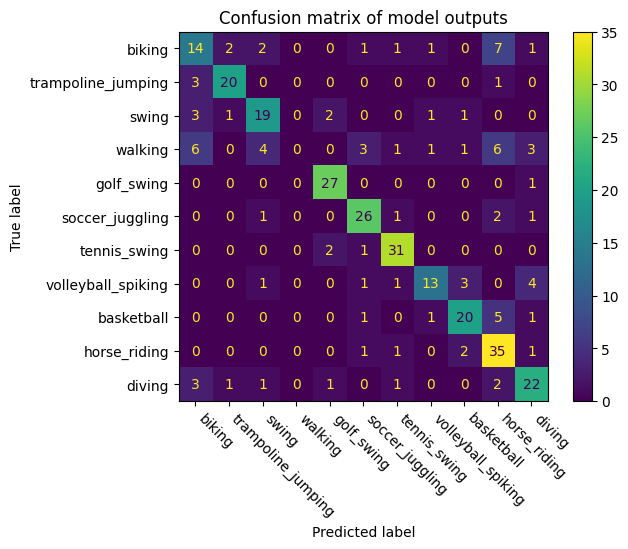

In [ ]:
# Calculate metrics and draw confusion matrix
model.module.load_state_dict(torch.load(CHECKPOINT_PATH, weights_only=True))

model.eval()
y_target = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for data, target in test_loader:
        y_target = np.concatenate([y_target, target])
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data).argmax(dim=1, keepdim=False).cpu().numpy()
        y_pred = np.concatenate([y_pred, output])

accuracy = accuracy_score(y_target, y_pred)
precision = precision_score(y_target, y_pred, zero_division=0, average='macro')
recall = recall_score(y_target, y_pred, zero_division=0, average='macro')
f1 = f1_score(y_target, y_pred, zero_division=0, average='macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

display = ConfusionMatrixDisplay(confusion_matrix(y_target, y_pred), display_labels=labels)
display.plot()
plt.xticks(rotation=-45, ha='left')
plt.title("Confusion matrix of model outputs")
plt.show()